# FedCAD: Federated vs Centralized Learning Analysis

This notebook provides comprehensive analysis and visualization of experiments comparing **Centralized** and **Federated Learning** approaches for breast cancer classification.

## ⚕️ Medical Focus: **Recall (Sensitivity) is Critical**

In medical diagnosis, **recall** is the most important metric because:
- **False negatives are dangerous**: Missing a cancer case can be life-threatening
- **Early detection saves lives**: High recall ensures we catch most true cases
- **Patient safety first**: Better to have false positives than miss actual cancer

This analysis gives special attention to recall performance across all approaches.

## 📋 Notebook Contents:

1. **Performance Metrics Comparison** - Side-by-side comparison of accuracy, precision, **recall**, F1, and AUC-ROC
2. **Recall Analysis** - Dedicated section highlighting recall performance (critical for medical diagnosis)
3. **Training Efficiency** - Analysis of training time vs performance trade-offs
4. **Training Progress** - Evolution of metrics during training
5. **Federated Configuration Trade-offs** - Impact of local epochs vs server rounds on performance and efficiency
6. **Detailed Model Analysis** - ROC curves, confusion matrices, and classification reports
7. **Summary Statistics** - Key insights and best configurations with focus on recall
8. **Export Results** - Save results for reporting

## 🚀 Quick Start:

1. Run all cells in order
2. Results are fetched from W&B or loaded from CSV (fallback mode)
3. Visualizations and insights are generated automatically
4. Results are exported to `results/` directory

---

## Visualizations

### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from torchvision.transforms import Compose, Normalize, ToTensor
from medmnist import BreastMNIST
from torch.utils.data import DataLoader

# Import your model and utility functions
import sys
sys.path.append('..')
from FedCAD.task import Net, load_data, test

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [22]:
# Optional: Install wandb if not already installed
# !pip install wandb -q

## 1. WandB Runs Comparison

**Note on Reproducibility**: This notebook can run in two modes:
- **WandB Mode**: Fetches live data from WandB (requires authentication and project access)
- **Offline Mode**: Uses exported CSV data (`wandb_runs_export.csv`) for reproducibility

The model evaluation section (Section 2) works independently and only requires the saved model file.

## Comparing Federated vs Centralized Training

This notebook compares multiple training approaches:
- **Centralized**: All data trained in one place (baseline)
- **Federated (FedAvg)**: Standard federated averaging aggregation
- **Federated (FedProx)**: Proximal term regularization for heterogeneous data
- **Differential Privacy**: Privacy-preserving training with noise addition

### Key Metrics:
- **Performance**: accuracy, precision, **recall (CRITICAL for medical diagnosis)**, F1, AUC-ROC
- **Efficiency**: training time, convergence speed
- **Trade-offs**: communication rounds vs epochs, privacy vs accuracy/recall
- **Privacy**: differential privacy budget (ε, δ)

### 🎯 Primary Evaluation Focus:
**Recall (Sensitivity)** - The ability to correctly identify cancer cases. This is the most critical metric for medical diagnosis where false negatives (missing cancer) can have severe consequences.

In [13]:
# Fetch runs from WandB API (if authenticated) or load from CSV
import wandb

try:
    api = wandb.Api()
    runs = api.runs("FedCAD", filters={"group": "comparison"})
    
    # Collect run data with all metrics
    run_data = []
    for run in runs:
        training_type = run.config.get('training_type', 'unknown')
        tags = run.tags if hasattr(run, 'tags') else []
        
        data = {
            'run_id': run.id,
            'name': run.name,
            'training_type': training_type,
            'tags': ','.join(tags),  # Store tags as comma-separated string
            'state': run.state,
            'lr': run.config.get('lr', None),
            'final_test_acc': run.summary.get('final_test_acc', None),
            'final_test_loss': run.summary.get('final_test_loss', None),
            'final_precision': run.summary.get('final_precision', None),
            'final_recall': run.summary.get('final_recall', None),
            'final_f1': run.summary.get('final_f1', None),
            'final_auc_roc': run.summary.get('final_auc_roc', None),
            'total_training_time_min': run.summary.get('total_training_time_min', None),
            'created_at': run.created_at,
        }
        
        # Add type-specific metrics
        if training_type == 'centralized':
            data['epochs'] = run.config.get('epochs', None)
            data['total_steps'] = run.config.get('epochs', 0)
            data['approach'] = 'centralized'
        elif training_type == 'federated':
            data['num_rounds'] = run.config.get('num_rounds', None)
            data['local_epochs'] = run.config.get('local_epochs', None)
            data['total_local_epochs'] = run.config.get('total_local_epochs', None)
            data['total_steps'] = run.config.get('total_local_epochs', 0)
            
            # Determine approach from tags
            if 'dp-fedavg' in tags:
                data['approach'] = 'dp-fedavg'
            elif 'dp-fedprox' in tags:
                data['approach'] = 'dp-fedprox'
            elif 'fedavg' in tags:
                data['approach'] = 'fedavg'
            elif 'fedprox' in tags:
                data['approach'] = 'fedprox'
            else:
                # Fallback to config if tags not available
                aggregation = run.config.get('aggregation', run.config.get('strategy', 'FedAvg'))
                dp_enabled = run.config.get('dp_enabled', False)
                if dp_enabled:
                    data['approach'] = f"dp-{aggregation.lower()}"
                else:
                    data['approach'] = aggregation.lower()
            
            # Store DP settings if applicable
            if 'dp-' in data['approach']:
                data['noise_multiplier'] = run.config.get('noise_multiplier', None)
                data['max_grad_norm'] = run.config.get('max_grad_norm', None)
                data['dp_delta'] = run.config.get('dp_delta', None)
                data['dp_epsilon'] = run.summary.get('dp_epsilon', None)
        
        run_data.append(data)
    
    df_comparison = pd.DataFrame(run_data)
    df_comparison.to_csv('wandb_comparison_export.csv', index=False)
    print(f"✅ Fetched {len(df_comparison)} runs from WandB (group='comparison')")
    
except Exception as e:
    print(f"⚠️ Could not fetch from WandB: {e}")
    print("Trying to load from CSV...")
    try:
        df_comparison = pd.read_csv('wandb_comparison_export.csv')
        print(f"✅ Loaded {len(df_comparison)} runs from CSV")
    except:
        print("❌ No data available")
        df_comparison = pd.DataFrame()

if not df_comparison.empty:
    # Ensure approach column exists (backward compatibility)
    if 'approach' not in df_comparison.columns:
        df_comparison['approach'] = df_comparison.apply(
            lambda x: 'centralized' if x['training_type'] == 'centralized' else 'fedavg', axis=1
        )
    
    print(f"\nData Summary:")
    print(f"  Total runs: {len(df_comparison)}")
    print(f"\nBy approach:")
    for approach in df_comparison['approach'].unique():
        count = len(df_comparison[df_comparison['approach'] == approach])
        print(f"    - {approach}: {count}")
    
    display_cols = ['name', 'approach', 'final_test_acc', 'final_f1', 'total_training_time_min']
    display(df_comparison[display_cols].head(10))

✅ Fetched 71 runs from WandB (group='comparison')

Data Summary:
  Total runs: 71

By approach:
    - centralized: 5
    - fedavg: 42
    - dp-fedavg: 6
    - dp-fedprox: 12
    - fedprox: 6


,name,approach,final_test_acc,final_f1,total_training_time_min
0,central_lr0.001_ep30,centralized,0.872727,0.857879,0.153069
1,central_lr0.001_ep30,centralized,0.809091,0.771499,0.126154
2,central_lr0.001_ep30,centralized,0.845455,0.842079,0.110088
3,central_lr0.001_ep30,centralized,0.836364,0.831448,0.102959
4,central_lr0.001_ep30,centralized,0.863636,0.862703,0.110758
5,federated_lr0.001_r3_le10,fedavg,0.754545,0.740364,0.333043
6,federated_lr0.001_r3_le10,fedavg,0.772727,0.774191,0.217928
7,federated_lr0.001_r3_le10,fedavg,0.754545,0.735099,0.213160
8,federated_lr0.001_r3_le10,fedavg,0.745455,0.733242,0.209461
9,federated_lr0.001_r3_le10,fedavg,0.709091,0.723345,0.239761


### 1. Performance Metrics Comparison

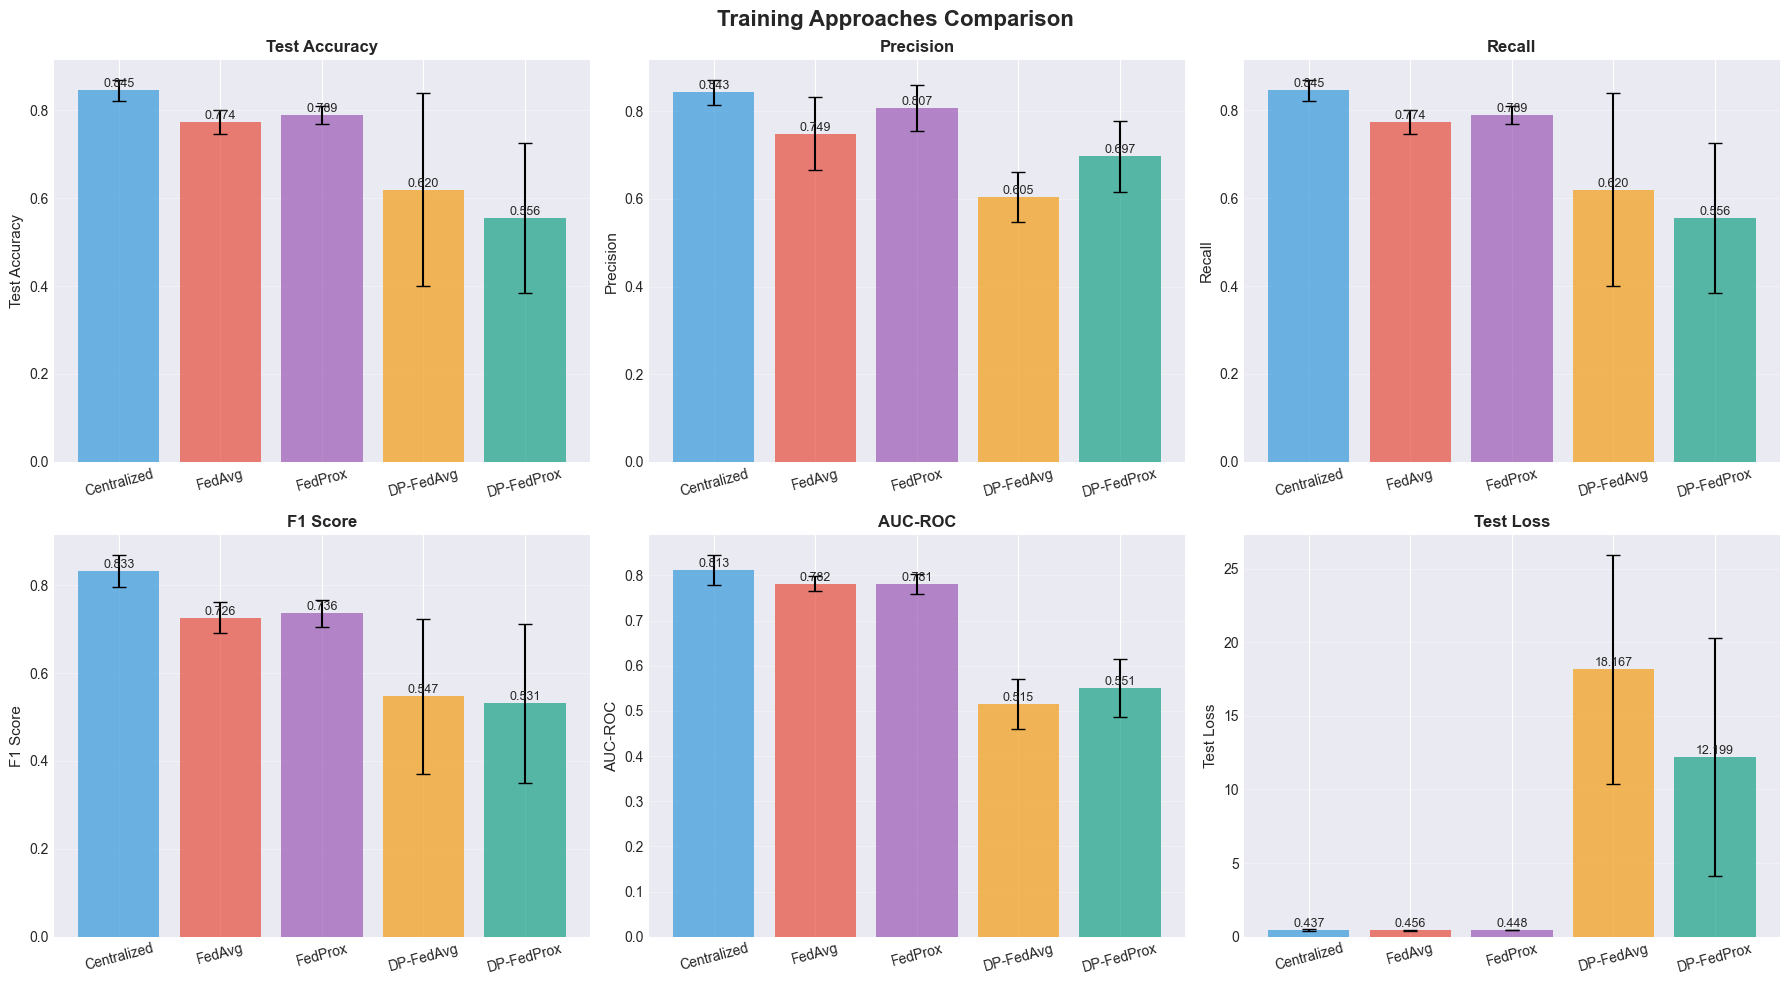


📊 Numerical Comparison (Mean ± Std):
Test Accuracy        | Central: 0.845±0.025 | FedAvg: 0.774±0.028 | FedProx: 0.789±0.020 | DP-FedAvg: 0.620±0.219 | DP-FedProx: 0.556±0.171
Precision            | Central: 0.843±0.029 | FedAvg: 0.749±0.084 | FedProx: 0.807±0.053 | DP-FedAvg: 0.605±0.057 | DP-FedProx: 0.697±0.081
Recall               | Central: 0.845±0.025 | FedAvg: 0.774±0.028 | FedProx: 0.789±0.020 | DP-FedAvg: 0.620±0.219 | DP-FedProx: 0.556±0.171
F1 Score             | Central: 0.833±0.037 | FedAvg: 0.726±0.036 | FedProx: 0.736±0.030 | DP-FedAvg: 0.547±0.176 | DP-FedProx: 0.531±0.181
AUC-ROC              | Central: 0.813±0.034 | FedAvg: 0.782±0.016 | FedProx: 0.781±0.023 | DP-FedAvg: 0.515±0.055 | DP-FedProx: 0.551±0.064
Test Loss            | Central: 0.437±0.059 | FedAvg: 0.456±0.033 | FedProx: 0.448±0.023 | DP-FedAvg: 18.167±7.785 | DP-FedProx: 12.199±8.078


In [14]:
if not df_comparison.empty:
    # Filter by approach
    centralized_runs = df_comparison[df_comparison['approach'] == 'centralized']
    fedavg_runs = df_comparison[df_comparison['approach'] == 'fedavg']
    fedprox_runs = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedavg_runs = df_comparison[df_comparison['approach'] == 'dp-fedavg']
    dp_fedprox_runs = df_comparison[df_comparison['approach'] == 'dp-fedprox']
    
    # Create comparison bar chart
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Training Approaches Comparison', fontsize=16, fontweight='bold')
    
    metrics = [
        ('final_test_acc', 'Test Accuracy', axes[0, 0]),
        ('final_precision', 'Precision', axes[0, 1]),
        ('final_recall', 'Recall', axes[0, 2]),
        ('final_f1', 'F1 Score', axes[1, 0]),
        ('final_auc_roc', 'AUC-ROC', axes[1, 1]),
        ('final_test_loss', 'Test Loss', axes[1, 2])
    ]
    
    for metric, label, ax in metrics:
        if centralized_runs[metric].notna().any():
            x_labels = []
            y_vals = []
            err_vals = []
            colors = []
            
            # Centralized
            if centralized_runs[metric].notna().any():
                x_labels.append('Centralized')
                y_vals.append(centralized_runs[metric].mean())
                err_vals.append(centralized_runs[metric].std())
                colors.append('#3498db')
            
            # FedAvg
            if not fedavg_runs.empty and fedavg_runs[metric].notna().any():
                x_labels.append('FedAvg')
                y_vals.append(fedavg_runs[metric].mean())
                err_vals.append(fedavg_runs[metric].std())
                colors.append('#e74c3c')
            
            # FedProx
            if not fedprox_runs.empty and fedprox_runs[metric].notna().any():
                x_labels.append('FedProx')
                y_vals.append(fedprox_runs[metric].mean())
                err_vals.append(fedprox_runs[metric].std())
                colors.append('#9b59b6')
            
            # DP-FedAvg
            if not dp_fedavg_runs.empty and dp_fedavg_runs[metric].notna().any():
                x_labels.append('DP-FedAvg')
                y_vals.append(dp_fedavg_runs[metric].mean())
                err_vals.append(dp_fedavg_runs[metric].std())
                colors.append('#f39c12')
            
            # DP-FedProx
            if not dp_fedprox_runs.empty and dp_fedprox_runs[metric].notna().any():
                x_labels.append('DP-FedProx')
                y_vals.append(dp_fedprox_runs[metric].mean())
                err_vals.append(dp_fedprox_runs[metric].std())
                colors.append('#16a085')
            
            if len(x_labels) > 0:
                bars = ax.bar(x_labels, y_vals, yerr=err_vals, capsize=5, alpha=0.7, color=colors)
                ax.set_ylabel(label, fontsize=11)
                ax.set_title(label, fontsize=12, fontweight='bold')
                ax.grid(axis='y', alpha=0.3)
                ax.tick_params(axis='x', rotation=15)
                
                # Add value labels on bars
                for bar, val in zip(bars, y_vals):
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparison
    print("\n📊 Numerical Comparison (Mean ± Std):")
    print("="*120)
    for metric, label, _ in metrics:
        if centralized_runs[metric].notna().any():
            parts = [f"{label:20s}"]
            
            if centralized_runs[metric].notna().any():
                c_mean, c_std = centralized_runs[metric].mean(), centralized_runs[metric].std()
                parts.append(f"Central: {c_mean:.3f}±{c_std:.3f}")
            
            if not fedavg_runs.empty and fedavg_runs[metric].notna().any():
                fa_mean, fa_std = fedavg_runs[metric].mean(), fedavg_runs[metric].std()
                parts.append(f"FedAvg: {fa_mean:.3f}±{fa_std:.3f}")
            
            if not fedprox_runs.empty and fedprox_runs[metric].notna().any():
                fp_mean, fp_std = fedprox_runs[metric].mean(), fedprox_runs[metric].std()
                parts.append(f"FedProx: {fp_mean:.3f}±{fp_std:.3f}")
            
            if not dp_fedavg_runs.empty and dp_fedavg_runs[metric].notna().any():
                dfa_mean, dfa_std = dp_fedavg_runs[metric].mean(), dp_fedavg_runs[metric].std()
                parts.append(f"DP-FedAvg: {dfa_mean:.3f}±{dfa_std:.3f}")
            
            if not dp_fedprox_runs.empty and dp_fedprox_runs[metric].notna().any():
                dfp_mean, dfp_std = dp_fedprox_runs[metric].mean(), dp_fedprox_runs[metric].std()
                parts.append(f"DP-FedProx: {dfp_mean:.3f}±{dfp_std:.3f}")
            
            print(" | ".join(parts))
else:
    print("No comparison data available")

#### ⚕️ Critical Metric: Recall in Medical Diagnosis

**Why Recall is Crucial for Breast Cancer Detection:**

In medical diagnosis, **recall (sensitivity)** is especially important because:
- **False Negatives are Costly**: Missing a cancer case (false negative) can be life-threatening
- **Early Detection Saves Lives**: High recall ensures we catch most true cancer cases
- **Better Safe Than Sorry**: In medical contexts, it's better to have some false positives than to miss actual cases

**Trade-off**: While we aim for high recall, we also monitor precision to avoid excessive false alarms that could lead to unnecessary stress and follow-up procedures.

The analysis below focuses on recall performance across all training approaches.

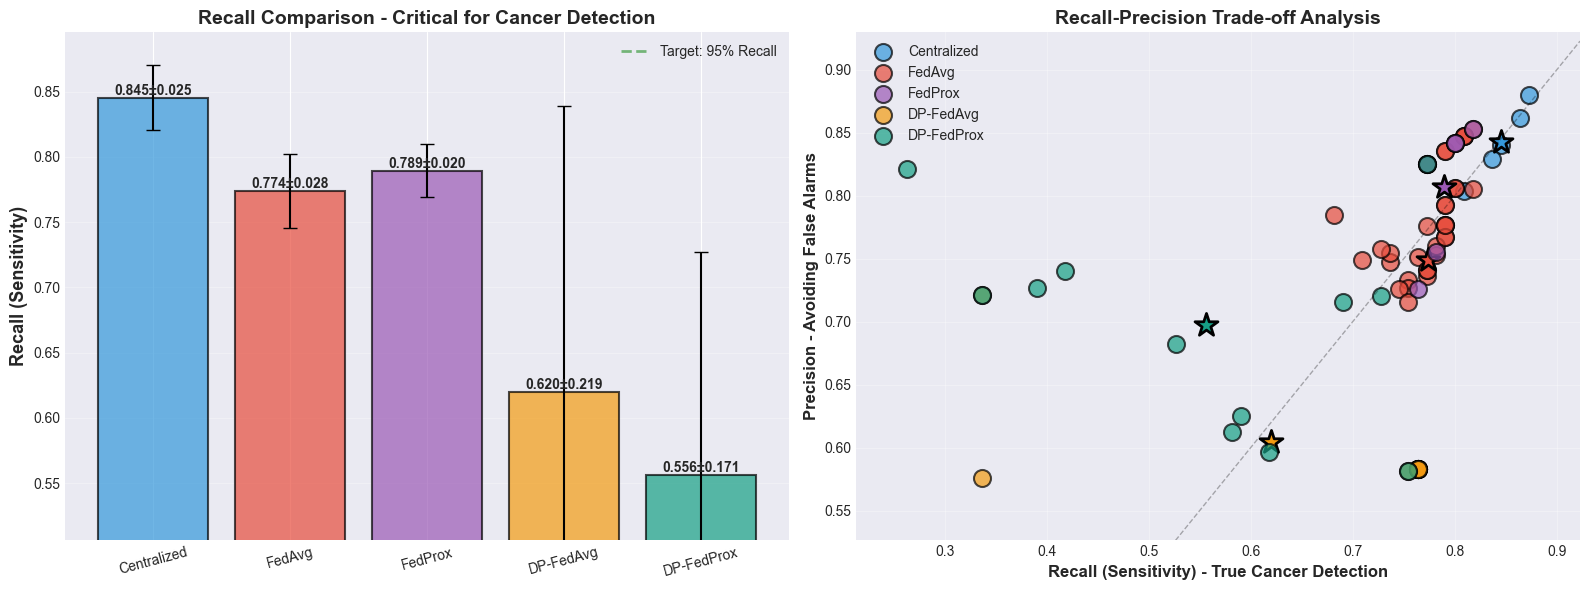


⚕️ RECALL ANALYSIS - Critical for Medical Diagnosis

Approach        Recall (Mean±Std)         Status                        
Centralized     0.8455 ± 0.0249        ❌ Needs Improvement (<85%)
FedAvg          0.7736 ± 0.0283        ❌ Needs Improvement (<85%)
FedProx         0.7894 ± 0.0203        ❌ Needs Improvement (<85%)
DP-FedAvg       0.6197 ± 0.2195        ❌ Needs Improvement (<85%)
DP-FedProx      0.5561 ± 0.1707        ❌ Needs Improvement (<85%)

💡 Key Findings:
   • Best recall: Centralized (0.8455)
     → Detects 84.55% of actual cancer cases
   • Lowest recall: DP-FedProx (0.5561)
     → Could miss 44.39% of actual cancer cases
   • Privacy cost on recall (FedAvg → DP-FedAvg): 0.1539 (15.39%)
   • Privacy cost on recall (FedProx → DP-FedProx): 0.2333 (23.33%)




In [ ]:
if not df_comparison.empty:
    # Dedicated Recall Analysis for Medical Diagnosis
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Define colors for different approaches
    style_map = {
        'centralized': {'color': '#3498db', 'label': 'Centralized'},
        'fedavg': {'color': '#e74c3c', 'label': 'FedAvg'},
        'fedprox': {'color': '#9b59b6', 'label': 'FedProx'},
        'dp-fedavg': {'color': '#f39c12', 'label': 'DP-FedAvg'},
        'dp-fedprox': {'color': '#16a085', 'label': 'DP-FedProx'},
    }
    
    # Plot 1: Recall Comparison Bar Chart
    ax = axes[0]
    recall_data = []
    labels = []
    colors_list = []
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            mean_val = approach_data['final_recall'].mean()
            std_val = approach_data['final_recall'].std() if len(approach_data) > 1 else 0
            recall_data.append((mean_val, std_val))
            labels.append(style_map[approach]['label'])
            colors_list.append(style_map[approach]['color'])
    
    if recall_data:
        means = [x[0] for x in recall_data]
        stds = [x[1] for x in recall_data]
        
        bars = ax.bar(labels, means, yerr=stds, capsize=5, alpha=0.7, color=colors_list,
                     edgecolor='black', linewidth=1.5)
        
        # Add a horizontal line at 0.95 (high recall target)
        ax.axhline(y=0.95, color='green', linestyle='--', linewidth=2, alpha=0.5, 
                  label='Target: 95% Recall')
        
        ax.set_ylabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
        ax.set_title('Recall Comparison - Critical for Cancer Detection', fontsize=14, fontweight='bold')
        
        # Set dynamic y-axis limits based on data
        min_recall = min(means) - 0.05
        max_recall = max(means) + 0.05
        ax.set_ylim([max(0, min_recall), min(1.0, max_recall)])
        
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        ax.legend(fontsize=10)
        
        # Add value labels on bars
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            if std > 0:
                label_text = f'{mean:.3f}±{std:.3f}'
            else:
                label_text = f'{mean:.3f}'
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   label_text, ha='center', va='bottom', 
                   fontsize=10, fontweight='bold')
    else:
        ax.text(0.5, 0.5, 'No recall data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Recall Comparison - Critical for Cancer Detection', fontsize=14, fontweight='bold')
    
    # Plot 2: Recall vs Precision Trade-off
    ax = axes[1]
    
    has_data = False
    all_recalls = []
    all_precisions = []
    
    for approach, style in style_map.items():
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if (not approach_data.empty and 
            'final_recall' in approach_data.columns and 
            'final_precision' in approach_data.columns and
            approach_data['final_recall'].notna().any() and 
            approach_data['final_precision'].notna().any()):
            
            recall_vals = approach_data['final_recall'].dropna()
            precision_vals = approach_data['final_precision'].dropna()
            
            # Ensure same length
            min_len = min(len(recall_vals), len(precision_vals))
            recall_vals = recall_vals.iloc[:min_len]
            precision_vals = precision_vals.iloc[:min_len]
            
            if len(recall_vals) > 0:
                has_data = True
                all_recalls.extend(recall_vals.values)
                all_precisions.extend(precision_vals.values)
                
                # Plot each run as a point
                ax.scatter(recall_vals, precision_vals, s=150, alpha=0.7,
                          color=style['color'], label=style['label'],
                          edgecolor='black', linewidth=1.5)
                
                # Add mean as a larger marker
                ax.scatter(recall_vals.mean(), precision_vals.mean(), s=300,
                          color=style['color'], marker='*', edgecolor='black', linewidth=2)
    
    if has_data:
        ax.set_xlabel('Recall (Sensitivity) - True Cancer Detection', fontsize=12, fontweight='bold')
        ax.set_ylabel('Precision - Avoiding False Alarms', fontsize=12, fontweight='bold')
        ax.set_title('Recall-Precision Trade-off Analysis', fontsize=14, fontweight='bold')
        
        # Set dynamic axis limits based on data
        min_recall = max(0, min(all_recalls) - 0.05)
        max_recall = min(1.0, max(all_recalls) + 0.05)
        min_precision = max(0, min(all_precisions) - 0.05)
        max_precision = min(1.0, max(all_precisions) + 0.05)
        
        ax.set_xlim([min_recall, max_recall])
        ax.set_ylim([min_precision, max_precision])
        
        # Add diagonal line showing F1 score (before legend)
        diag_min = max(min_recall, min_precision)
        diag_max = min(max_recall, max_precision)
        x = np.linspace(diag_min, diag_max, 100)
        ax.plot(x, x, 'k--', alpha=0.3, linewidth=1)
        
        # Add dummy entry for star marker in legend
        ax.scatter([], [], s=300, marker='*', color='gray', edgecolor='black', 
                  linewidth=2, label='Mean (per approach)')
        
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=10, loc='best')
    else:
        ax.text(0.5, 0.5, 'No precision-recall data available', 
               ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Recall-Precision Trade-off Analysis', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed recall analysis
    print("\n⚕️ RECALL ANALYSIS - Critical for Medical Diagnosis\n")
    print("="*80)
    print(f"{'Approach':<15} {'Recall (Mean±Std)':<25} {'Status':<30}")
    print("="*80)
    
    found_any = False
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            found_any = True
            mean_recall = approach_data['final_recall'].mean()
            std_recall = approach_data['final_recall'].std() if len(approach_data) > 1 else 0
            
            # Determine status
            if mean_recall >= 0.95:
                status = "✅ Excellent (≥95%)"
            elif mean_recall >= 0.90:
                status = "✓ Good (90-95%)"
            elif mean_recall >= 0.85:
                status = "⚠️ Acceptable (85-90%)"
            else:
                status = "❌ Needs Improvement (<85%)"
            
            if std_recall > 0:
                print(f"{style_map[approach]['label']:<15} {mean_recall:.4f} ± {std_recall:.4f}        {status}")
            else:
                print(f"{style_map[approach]['label']:<15} {mean_recall:.4f}                 {status}")
    
    if not found_any:
        print("   No recall data available for any approach")
    
    print("="*80)
    print("\n💡 Key Findings:")
    
    # Find best and worst recall
    best_recall_approach = None
    worst_recall_approach = None
    best_recall_val = 0
    worst_recall_val = 1
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and 'final_recall' in approach_data.columns and approach_data['final_recall'].notna().any():
            mean_recall = approach_data['final_recall'].mean()
            if mean_recall > best_recall_val:
                best_recall_val = mean_recall
                best_recall_approach = style_map[approach]['label']
            if mean_recall < worst_recall_val:
                worst_recall_val = mean_recall
                worst_recall_approach = style_map[approach]['label']
    
    if best_recall_approach:
        print(f"   • Best recall: {best_recall_approach} ({best_recall_val:.4f})")
        print(f"     → Detects {best_recall_val*100:.2f}% of actual cancer cases")
    
    if worst_recall_approach:
        missed_cases = (1 - worst_recall_val) * 100
        print(f"   • Lowest recall: {worst_recall_approach} ({worst_recall_val:.4f})")
        print(f"     → Could miss {missed_cases:.2f}% of actual cancer cases")
    
    # Privacy impact on recall
    fedavg_data = df_comparison[df_comparison['approach'] == 'fedavg']
    dp_fedavg_data = df_comparison[df_comparison['approach'] == 'dp-fedavg']
    if (not fedavg_data.empty and not dp_fedavg_data.empty and 
        'final_recall' in fedavg_data.columns and 'final_recall' in dp_fedavg_data.columns):
        if fedavg_data['final_recall'].notna().any() and dp_fedavg_data['final_recall'].notna().any():
            recall_drop = fedavg_data['final_recall'].mean() - dp_fedavg_data['final_recall'].mean()
            print(f"   • Privacy cost on recall (FedAvg → DP-FedAvg): {recall_drop:.4f} ({recall_drop*100:.2f}%)")
    
    fedprox_data = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedprox_data = df_comparison[df_comparison['approach'] == 'dp-fedprox']
    if (not fedprox_data.empty and not dp_fedprox_data.empty and 
        'final_recall' in fedprox_data.columns and 'final_recall' in dp_fedprox_data.columns):
        if fedprox_data['final_recall'].notna().any() and dp_fedprox_data['final_recall'].notna().any():
            recall_drop = fedprox_data['final_recall'].mean() - dp_fedprox_data['final_recall'].mean()
            print(f"   • Privacy cost on recall (FedProx → DP-FedProx): {recall_drop:.4f} ({recall_drop*100:.2f}%)")
    
    if not best_recall_approach:
        print("   No recall data available for comparison")
    
    print("\n")
else:
    print("No data available for recall analysis")

### 2. Training Efficiency: Accuracy vs Time

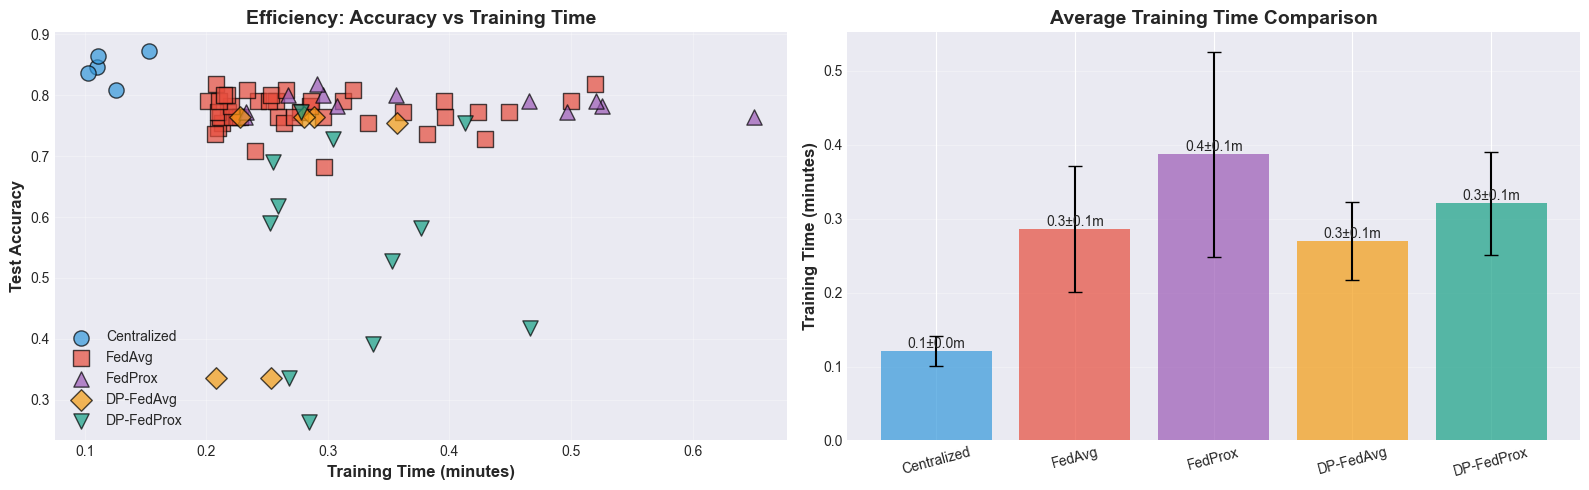


⏱️ Training Efficiency:
Centralized: 0.12 ± 0.02 minutes
FedAvg: 0.29 ± 0.09 minutes
FedProx: 0.39 ± 0.14 minutes
DP-FedAvg: 0.27 ± 0.05 minutes
DP-FedProx: 0.32 ± 0.07 minutes


In [7]:
if not df_comparison.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Plot 1: Accuracy vs Training Time with color-coded approaches
    ax = axes[0]
    
    # Define colors and markers for different approaches
    style_map = {
        'centralized': {'color': '#3498db', 'marker': 'o', 'label': 'Centralized'},
        'fedavg': {'color': '#e74c3c', 'marker': 's', 'label': 'FedAvg'},
        'fedprox': {'color': '#9b59b6', 'marker': '^', 'label': 'FedProx'},
        'dp-fedavg': {'color': '#f39c12', 'marker': 'D', 'label': 'DP-FedAvg'},
        'dp-fedprox': {'color': '#16a085', 'marker': 'v', 'label': 'DP-FedProx'},
    }
    
    # Plot each approach
    for approach, style in style_map.items():
        data = df_comparison[df_comparison['approach'] == approach]
        if not data.empty:
            ax.scatter(data['total_training_time_min'], data['final_test_acc'],
                      s=120, alpha=0.7, edgecolors='black', linewidth=1, **style)
    
    ax.set_xlabel('Training Time (minutes)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Efficiency: Accuracy vs Training Time', fontsize=14, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Training time comparison across all approaches
    ax = axes[1]
    
    time_data = []
    labels = []
    colors_list = []
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and approach_data['total_training_time_min'].notna().any():
            time_data.append((approach_data['total_training_time_min'].mean(),
                             approach_data['total_training_time_min'].std()))
            labels.append(style_map[approach]['label'])
            colors_list.append(style_map[approach]['color'])
    
    if time_data:
        means = [x[0] for x in time_data]
        stds = [x[1] for x in time_data]
        
        bars = ax.bar(labels, means, yerr=stds, capsize=5, alpha=0.7, color=colors_list)
        
        ax.set_ylabel('Training Time (minutes)', fontsize=12, fontweight='bold')
        ax.set_title('Average Training Time Comparison', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)
        ax.tick_params(axis='x', rotation=15)
        
        # Add value labels
        for bar, mean, std in zip(bars, means, stds):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{mean:.1f}±{std:.1f}m', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n⏱️ Training Efficiency:")
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and approach_data['total_training_time_min'].notna().any():
            mean_time = approach_data['total_training_time_min'].mean()
            std_time = approach_data['total_training_time_min'].std()
            print(f"{style_map[approach]['label']}: {mean_time:.2f} ± {std_time:.2f} minutes")
else:
    print("No timing data available")

### 3. Training Progress Over Time

Visualize how test accuracy and loss evolve during training for both approaches.

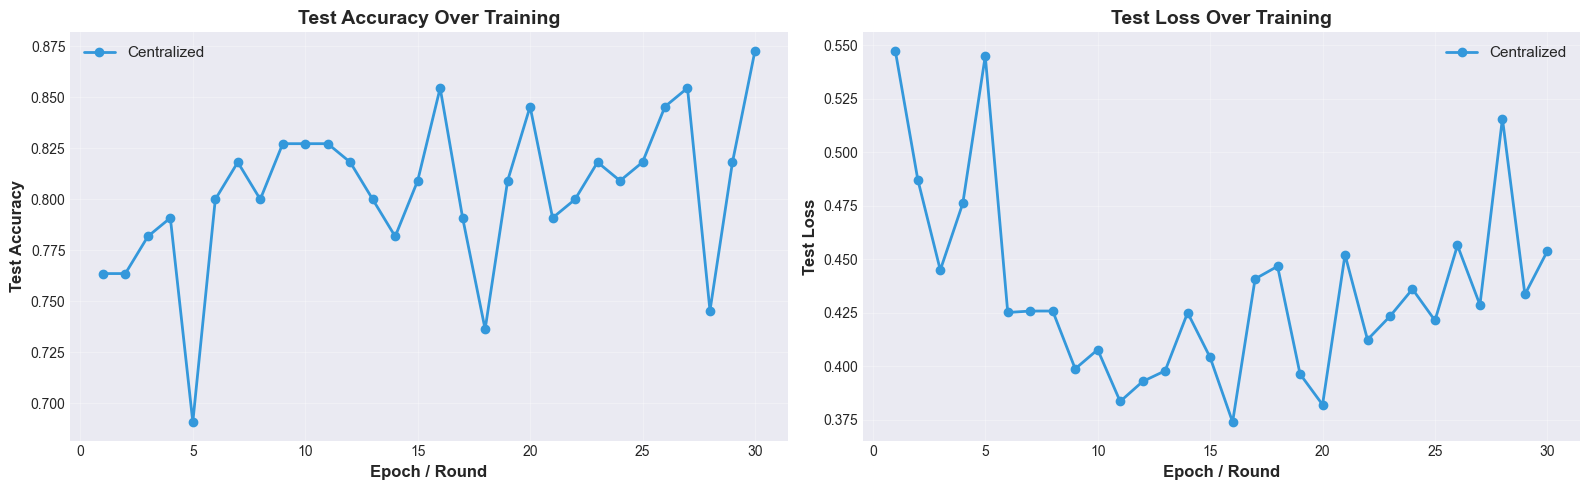

In [8]:
if not df_comparison.empty and len(df_comparison) > 0:
    try:
        # Fetch training history for best run of each type
        api = wandb.Api()
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        
        for training_type, color, ax_idx in [('centralized', '#3498db', 0), 
                                              ('federated', '#e74c3c', 1)]:
            runs_of_type = df_comparison[df_comparison['training_type'] == training_type]
            if not runs_of_type.empty:
                # Get best run
                best_run_id = runs_of_type.nlargest(1, 'final_test_acc').iloc[0]['run_id']
                run = api.run(f"FedCAD/{best_run_id}")
                history = run.history()
                
                # Plot test accuracy over time
                if training_type == 'centralized' and 'test_acc' in history.columns:
                    history_clean = history[history['test_acc'].notna()]
                    axes[0].plot(history_clean['epoch'], history_clean['test_acc'],
                               marker='o', linewidth=2, color=color, 
                               label=f'{training_type.capitalize()}', markersize=6)
                    axes[1].plot(history_clean['epoch'], history_clean['test_loss'],
                               marker='o', linewidth=2, color=color,
                               label=f'{training_type.capitalize()}', markersize=6)
                    
                elif training_type == 'federated' and 'test_acc' in history.columns:
                    history_clean = history[history['test_acc'].notna()]
                    axes[0].plot(history_clean['round'], history_clean['test_acc'],
                               marker='s', linewidth=2, color=color,
                               label=f'{training_type.capitalize()}', markersize=6)
                    axes[1].plot(history_clean['round'], history_clean['test_loss'],
                               marker='s', linewidth=2, color=color,
                               label=f'{training_type.capitalize()}', markersize=6)
        
        # Format accuracy plot
        axes[0].set_xlabel('Epoch / Round', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        axes[0].set_title('Test Accuracy Over Training', fontsize=14, fontweight='bold')
        axes[0].legend(fontsize=11)
        axes[0].grid(True, alpha=0.3)
        
        # Format loss plot
        axes[1].set_xlabel('Epoch / Round', fontsize=12, fontweight='bold')
        axes[1].set_ylabel('Test Loss', fontsize=12, fontweight='bold')
        axes[1].set_title('Test Loss Over Training', fontsize=14, fontweight='bold')
        axes[1].legend(fontsize=11)
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not fetch training history: {e}")
        print("Skipping training progress plots")
else:
    print("No data available for training progress plots")

### 4. Federated Learning Configuration Trade-offs

Compare different federated learning setups: local epochs vs server rounds, and their impact on performance and efficiency.

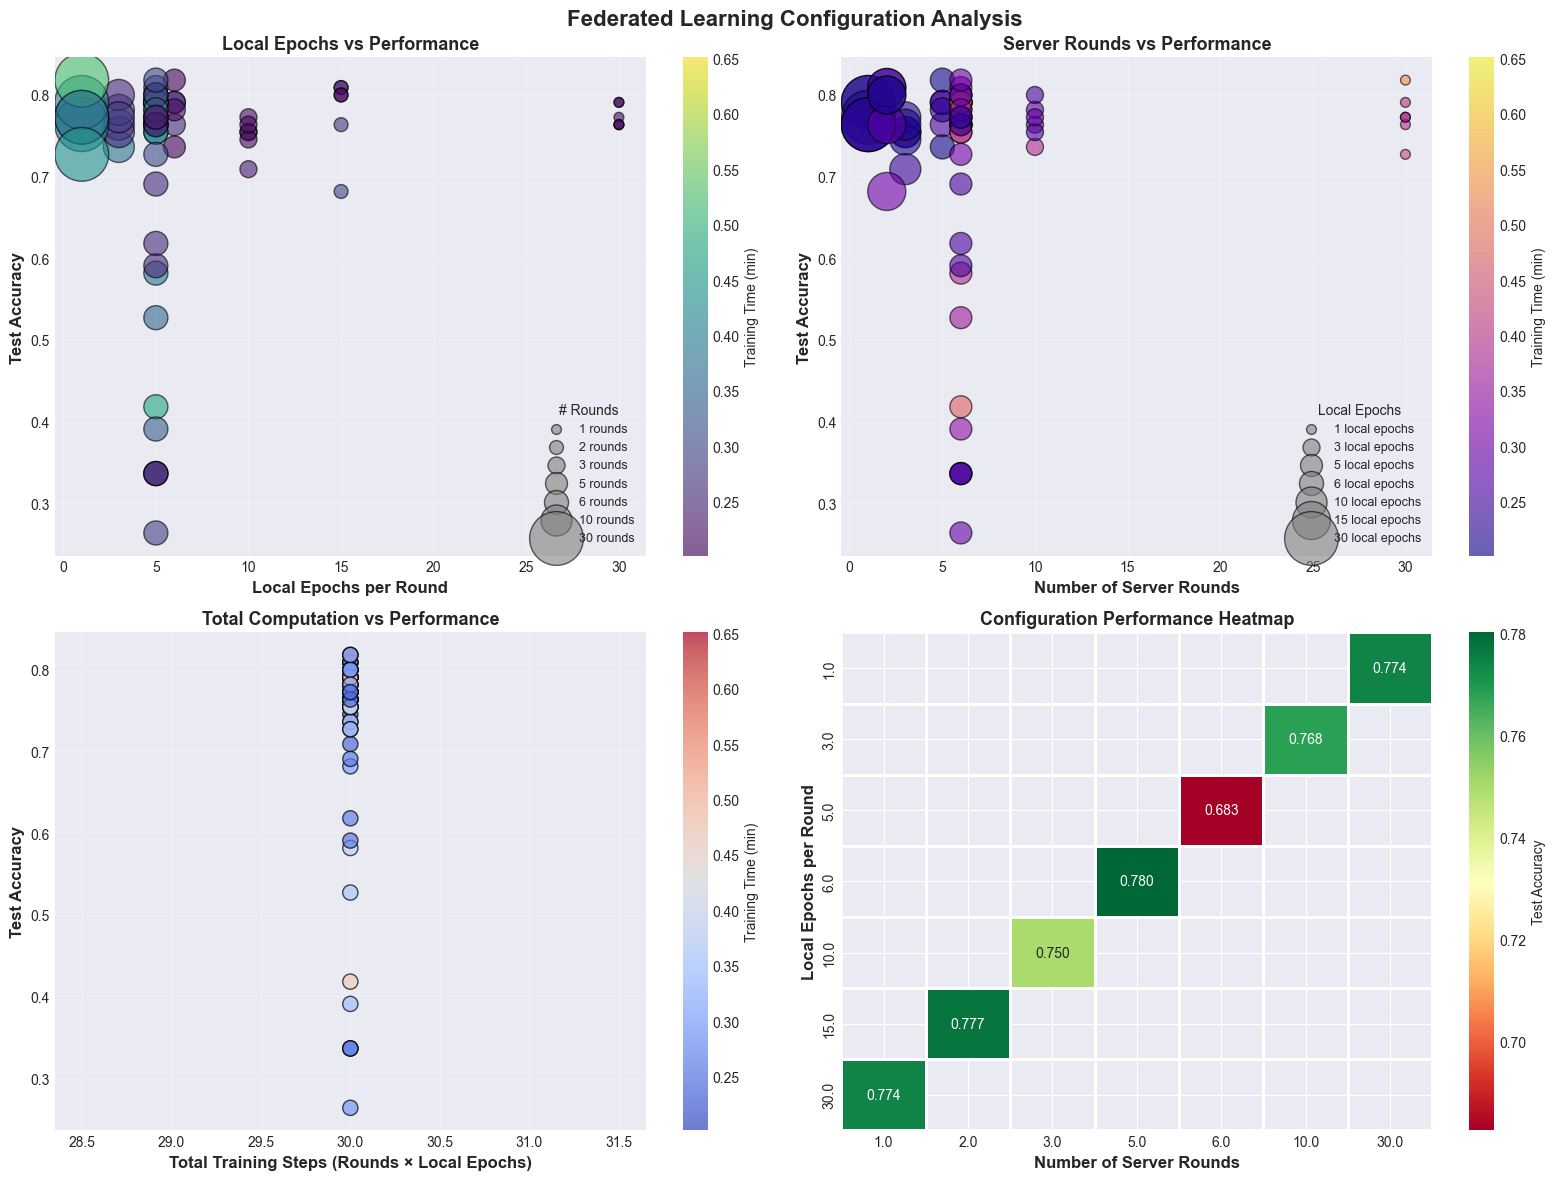


🔍 Federated Configuration Analysis:
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.755 | Time: 0.33min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.773 | Time: 0.22min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.755 | Time: 0.21min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.745 | Time: 0.21min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.709 | Time: 0.24min
Rounds: 3 | Local Epochs: 10 | Total Steps: 30 | Accuracy: 0.764 | Time: 0.21min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.791 | Time: 0.26min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.791 | Time: 0.20min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.764 | Time: 0.23min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.773 | Time: 0.21min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.764 | Time: 0.23min
Rounds: 1 | Local Epochs: 30 | Total Steps: 30 | Accuracy: 0.764 | Time:

In [9]:
if not df_comparison.empty:
    federated_only = df_comparison[df_comparison['training_type'] == 'federated'].copy()
    
    if not federated_only.empty and len(federated_only) > 1:
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Federated Learning Configuration Analysis', fontsize=16, fontweight='bold')
        
        # Plot 1: Local Epochs vs Accuracy
        ax = axes[0, 0]
        scatter = ax.scatter(federated_only['local_epochs'], federated_only['final_test_acc'],
                           s=federated_only['num_rounds']*50, alpha=0.6, 
                           c=federated_only['total_training_time_min'], cmap='viridis',
                           edgecolors='black', linewidth=1)
        ax.set_xlabel('Local Epochs per Round', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Local Epochs vs Performance', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Training Time (min)', fontsize=10)
        
        # Add legend for bubble size
        for rounds in sorted(federated_only['num_rounds'].dropna().unique()):
            ax.scatter([], [], s=rounds*50, c='gray', alpha=0.6, 
                      edgecolors='black', linewidth=1,
                      label=f'{int(rounds)} rounds')
        ax.legend(title='# Rounds', loc='lower right', fontsize=9)
        
        # Plot 2: Server Rounds vs Accuracy
        ax = axes[0, 1]
        scatter = ax.scatter(federated_only['num_rounds'], federated_only['final_test_acc'],
                           s=federated_only['local_epochs']*50, alpha=0.6,
                           c=federated_only['total_training_time_min'], cmap='plasma',
                           edgecolors='black', linewidth=1)
        ax.set_xlabel('Number of Server Rounds', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Server Rounds vs Performance', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Training Time (min)', fontsize=10)
        
        # Add legend for bubble size
        for epochs in sorted(federated_only['local_epochs'].dropna().unique()):
            ax.scatter([], [], s=epochs*50, c='gray', alpha=0.6,
                      edgecolors='black', linewidth=1,
                      label=f'{int(epochs)} local epochs')
        ax.legend(title='Local Epochs', loc='lower right', fontsize=9)
        
        # Plot 3: Total Training Steps (rounds × local_epochs) vs Efficiency
        ax = axes[1, 0]
        federated_only['total_steps'] = federated_only['num_rounds'] * federated_only['local_epochs']
        scatter = ax.scatter(federated_only['total_steps'], federated_only['final_test_acc'],
                           s=120, alpha=0.7, c=federated_only['total_training_time_min'],
                           cmap='coolwarm', edgecolors='black', linewidth=1)
        ax.set_xlabel('Total Training Steps (Rounds × Local Epochs)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
        ax.set_title('Total Computation vs Performance', fontsize=13, fontweight='bold')
        ax.grid(True, alpha=0.3)
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Training Time (min)', fontsize=10)
        
        # Plot 4: Configuration Efficiency Heatmap
        ax = axes[1, 1]
        if federated_only['num_rounds'].notna().any() and federated_only['local_epochs'].notna().any():
            # Create pivot table for heatmap
            pivot_data = federated_only.pivot_table(
                values='final_test_acc',
                index='local_epochs',
                columns='num_rounds',
                aggfunc='mean'
            )
            
            if not pivot_data.empty:
                sns.heatmap(pivot_data, annot=True, fmt='.3f', cmap='RdYlGn',
                           ax=ax, cbar_kws={'label': 'Test Accuracy'},
                           linewidths=1, linecolor='white')
                ax.set_xlabel('Number of Server Rounds', fontsize=12, fontweight='bold')
                ax.set_ylabel('Local Epochs per Round', fontsize=12, fontweight='bold')
                ax.set_title('Configuration Performance Heatmap', fontsize=13, fontweight='bold')
            else:
                ax.text(0.5, 0.5, 'Insufficient data for heatmap', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title('Configuration Performance Heatmap', fontsize=13, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print configuration analysis
        print("\n🔍 Federated Configuration Analysis:")
        print("="*70)
        if 'total_steps' in federated_only.columns:
            for _, row in federated_only.iterrows():
                print(f"Rounds: {row['num_rounds']:.0f} | Local Epochs: {row['local_epochs']:.0f} | "
                      f"Total Steps: {row['total_steps']:.0f} | "
                      f"Accuracy: {row['final_test_acc']:.3f} | "
                      f"Time: {row['total_training_time_min']:.2f}min")
    else:
        print("Need at least 2 federated runs with different configurations for comparison")
else:
    print("No federated data available")

### 5. Model Performance Detailed Analysis

ROC curves, confusion matrices, and per-class metrics for the best models.

Using downloaded and verified file: /Users/louisewiljander/.medmnist/breastmnist.npz


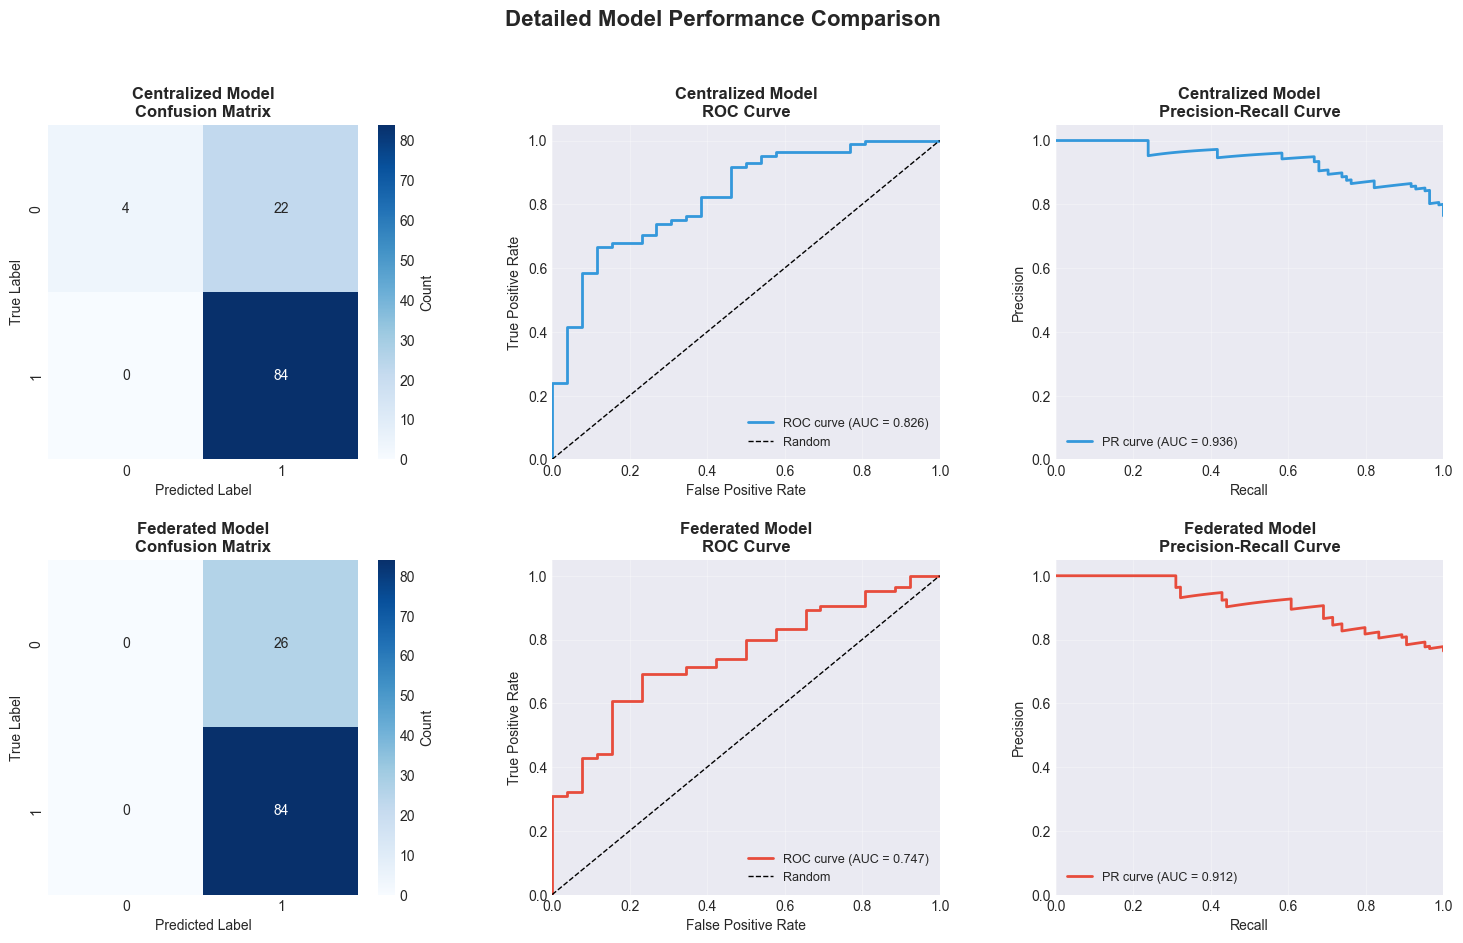


📈 Detailed Classification Metrics:


Centralized Model
              precision    recall  f1-score   support

     Class 0       1.00      0.15      0.27        26
     Class 1       0.79      1.00      0.88        84

    accuracy                           0.80       110
   macro avg       0.90      0.58      0.58       110
weighted avg       0.84      0.80      0.74       110


Federated Model
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        26
     Class 1       0.76      1.00      0.87        84

    accuracy                           0.76       110
   macro avg       0.38      0.50      0.43       110
weighted avg       0.58      0.76      0.66       110



/Users/louisewiljander/Documents/Projects/fl-lab/FedCAD/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/louisewiljander/Documents/Projects/fl-lab/FedCAD/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/louisewiljander/Documents/Projects/fl-lab/FedCAD/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

In [10]:
# Load and evaluate the best models from each approach
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_, testloader = load_data(0, 1)

def evaluate_model_detailed(model_path, model_name):
    """Evaluate model and return predictions, probabilities, and labels"""
    try:
        model = Net()
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.to(device)
        model.eval()
        
        all_preds, all_probs, all_labels = [], [], []
        
        with torch.no_grad():
            for images, labels in testloader:
                images = images.to(device)
                labels = labels.squeeze().long()
                outputs = model(images)
                probs = torch.softmax(outputs, dim=1)
                preds = torch.argmax(outputs, dim=1)
                
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        return (np.array(all_preds), np.array(all_probs), np.array(all_labels))
    except Exception as e:
        print(f"Could not load {model_name}: {e}")
        return None, None, None

# Evaluate both models
centralized_results = evaluate_model_detailed('models/final_model_centralized.pt', 'Centralized')
federated_results = evaluate_model_detailed('final_model.pt', 'Federated')

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

model_results = [
    ('Centralized', centralized_results, '#3498db'),
    ('Federated', federated_results, '#e74c3c')
]

for idx, (name, results, color) in enumerate(model_results):
    if results[0] is not None:
        preds, probs, labels = results
        
        # Confusion Matrix
        ax_cm = fig.add_subplot(gs[idx, 0])
        cm = confusion_matrix(labels, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax_cm,
                   cbar_kws={'label': 'Count'})
        ax_cm.set_title(f'{name} Model\nConfusion Matrix', fontsize=12, fontweight='bold')
        ax_cm.set_ylabel('True Label', fontsize=10)
        ax_cm.set_xlabel('Predicted Label', fontsize=10)
        
        # ROC Curve
        ax_roc = fig.add_subplot(gs[idx, 1])
        fpr, tpr, _ = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, color=color, lw=2, 
                   label=f'ROC curve (AUC = {roc_auc:.3f})')
        ax_roc.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
        ax_roc.set_xlim([0.0, 1.0])
        ax_roc.set_ylim([0.0, 1.05])
        ax_roc.set_xlabel('False Positive Rate', fontsize=10)
        ax_roc.set_ylabel('True Positive Rate', fontsize=10)
        ax_roc.set_title(f'{name} Model\nROC Curve', fontsize=12, fontweight='bold')
        ax_roc.legend(loc="lower right", fontsize=9)
        ax_roc.grid(True, alpha=0.3)
        
        # Precision-Recall Curve
        ax_pr = fig.add_subplot(gs[idx, 2])
        precision, recall, _ = precision_recall_curve(labels, probs[:, 1])
        pr_auc = auc(recall, precision)
        ax_pr.plot(recall, precision, color=color, lw=2,
                  label=f'PR curve (AUC = {pr_auc:.3f})')
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.set_xlabel('Recall', fontsize=10)
        ax_pr.set_ylabel('Precision', fontsize=10)
        ax_pr.set_title(f'{name} Model\nPrecision-Recall Curve', fontsize=12, fontweight='bold')
        ax_pr.legend(loc="lower left", fontsize=9)
        ax_pr.grid(True, alpha=0.3)

fig.suptitle('Detailed Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.show()

# Print classification reports
print("\n📈 Detailed Classification Metrics:\n")
for name, results, _ in model_results:
    if results[0] is not None:
        preds, _, labels = results
        print(f"\n{'='*50}")
        print(f"{name} Model")
        print(f"{'='*50}")
        print(classification_report(labels, preds, target_names=['Class 0', 'Class 1']))

### 6. Summary Statistics & Key Insights

In [ ]:
if not df_comparison.empty:
    print("="*80)
    print(" "*25 + "EXPERIMENT SUMMARY")
    print("="*80)
    
    # Overall statistics
    centralized = df_comparison[df_comparison['approach'] == 'centralized']
    federated = df_comparison[df_comparison['training_type'] == 'federated']
    
    print(f"\n📊 Dataset & Training Overview:")
    print(f"   Total Experiments: {len(df_comparison)}")
    print(f"   By Approach:")
    for approach in df_comparison['approach'].unique():
        count = len(df_comparison[df_comparison['approach'] == approach])
        print(f"      - {approach}: {count}")
    
    # Performance comparison
    print(f"\n🎯 Performance Comparison:")
    print(f"   {'Metric':<20} {'Centralized':<18} {'FedAvg':<18} {'FedProx':<18} {'DP-FedAvg':<18} {'DP-FedProx':<18}")
    print(f"   {'-'*110}")
    
    metrics_to_compare = [
        ('final_test_acc', 'Test Accuracy'),
        ('final_precision', 'Precision'),
        ('final_recall', 'Recall'),
        ('final_f1', 'F1 Score'),
        ('final_auc_roc', 'AUC-ROC'),
    ]
    
    for metric, label in metrics_to_compare:
        parts = [f"   {label:<20}"]
        
        for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and metric in approach_data.columns and approach_data[metric].notna().any():
                val = approach_data[metric].mean()
                std = approach_data[metric].std()
                parts.append(f"{val:.3f}±{std:.3f}      ")
            else:
                parts.append(f"{'N/A':<18}")
        
        print(''.join(parts))
    
    # Efficiency comparison
    print(f"\n⏱️  Efficiency Comparison:")
    parts = [f"   {'Training Time':<20}"]
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty and approach_data['total_training_time_min'].notna().any():
            val = approach_data['total_training_time_min'].mean()
            std = approach_data['total_training_time_min'].std()
            parts.append(f"{val:.2f}±{std:.2f} min   ")
        else:
            parts.append(f"{'N/A':<18}")
    
    print(''.join(parts))
    
    # Best configurations by approach
    print(f"\n🏆 Best Configurations:")
    
    for approach in ['centralized', 'fedavg', 'fedprox', 'dp-fedavg', 'dp-fedprox']:
        approach_data = df_comparison[df_comparison['approach'] == approach]
        if not approach_data.empty:
            best_run = approach_data.nlargest(1, 'final_test_acc').iloc[0]
            print(f"\n   {approach.upper()}:")
            print(f"      Name: {best_run['name']}")
            print(f"      Accuracy: {best_run['final_test_acc']:.4f}")
            print(f"      F1 Score: {best_run['final_f1']:.4f}")
            print(f"      Training Time: {best_run['total_training_time_min']:.2f} min")
            
            if approach == 'centralized' and 'epochs' in best_run:
                print(f"      Epochs: {best_run['epochs']:.0f}")
            elif approach != 'centralized' and 'num_rounds' in best_run and 'local_epochs' in best_run:
                print(f"      Configuration: {best_run['num_rounds']:.0f} rounds × "
                      f"{best_run['local_epochs']:.0f} local epochs = "
                      f"{best_run['num_rounds'] * best_run['local_epochs']:.0f} total steps")
    
    # Key insights
    print(f"\n💡 Key Insights:")
    
    # Recall-focused insights (most critical for medical diagnosis)
    print(f"\n   🏥 MEDICAL DIAGNOSIS PRIORITY - RECALL (Sensitivity):")
    if not centralized.empty:
        c_recall = centralized['final_recall'].mean()
        best_recall_approach = None
        best_recall_val = 0
        
        for approach, label in [('centralized', 'Centralized'), ('fedavg', 'FedAvg'), ('fedprox', 'FedProx'), 
                                ('dp-fedavg', 'DP-FedAvg'), ('dp-fedprox', 'DP-FedProx')]:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and approach_data['final_recall'].notna().any():
                a_recall = approach_data['final_recall'].mean()
                if a_recall > best_recall_val:
                    best_recall_val = a_recall
                    best_recall_approach = label
                
                if approach != 'centralized':
                    gap = a_recall - c_recall
                    if abs(gap) < 0.01:
                        print(f"      • {label} recall comparable to centralized: {a_recall:.4f} (Δ = {gap:+.4f})")
                    elif gap > 0:
                        print(f"      • {label} IMPROVES recall: {a_recall:.4f} ({gap:+.4f} better, {gap*100:+.2f}%)")
                    else:
                        missed_extra = abs(gap) * 100
                        print(f"      • {label} recall: {a_recall:.4f} ({gap:.4f} lower, ~{missed_extra:.1f}% more missed cases)")
        
        if best_recall_approach:
            print(f"\n      ✅ BEST for cancer detection: {best_recall_approach} with {best_recall_val:.4f} recall")
            print(f"         → Catches {best_recall_val*100:.2f}% of actual cancer cases")
    
    # Overall performance comparison
    print(f"\n   📊 Overall Performance (Accuracy):")
    if not centralized.empty:
        c_acc = centralized['final_test_acc'].mean()
        
        for approach, label in [('fedavg', 'FedAvg'), ('fedprox', 'FedProx'), 
                                ('dp-fedavg', 'DP-FedAvg'), ('dp-fedprox', 'DP-FedProx')]:
            approach_data = df_comparison[df_comparison['approach'] == approach]
            if not approach_data.empty and approach_data['final_test_acc'].notna().any():
                a_acc = approach_data['final_test_acc'].mean()
                gap = a_acc - c_acc
                if abs(gap) < 0.01:
                    print(f"      • {label} performance is comparable to centralized (Δ = {gap:+.4f})")
                elif gap > 0:
                    print(f"      • {label} achieves {gap:.4f} higher accuracy than centralized")
                else:
                    print(f"      • {label} achieves {abs(gap):.4f} lower accuracy than centralized")
    
    # Privacy-utility trade-off (including recall impact)
    print(f"\n   🔒 Privacy-Utility Trade-off:")
    fedavg_data = df_comparison[df_comparison['approach'] == 'fedavg']
    dp_fedavg_data = df_comparison[df_comparison['approach'] == 'dp-fedavg']
    if not fedavg_data.empty and not dp_fedavg_data.empty:
        if fedavg_data['final_test_acc'].notna().any() and dp_fedavg_data['final_test_acc'].notna().any():
            privacy_cost_acc = fedavg_data['final_test_acc'].mean() - dp_fedavg_data['final_test_acc'].mean()
            print(f"      • DP-FedAvg accuracy cost: {privacy_cost_acc:.4f} ({privacy_cost_acc*100:.2f}%)")
        if fedavg_data['final_recall'].notna().any() and dp_fedavg_data['final_recall'].notna().any():
            privacy_cost_recall = fedavg_data['final_recall'].mean() - dp_fedavg_data['final_recall'].mean()
            print(f"      • DP-FedAvg RECALL cost: {privacy_cost_recall:.4f} ({privacy_cost_recall*100:.2f}%) ⚕️ CRITICAL")
    
    fedprox_data = df_comparison[df_comparison['approach'] == 'fedprox']
    dp_fedprox_data = df_comparison[df_comparison['approach'] == 'dp-fedprox']
    if not fedprox_data.empty and not dp_fedprox_data.empty:
        if fedprox_data['final_test_acc'].notna().any() and dp_fedprox_data['final_test_acc'].notna().any():
            privacy_cost_acc = fedprox_data['final_test_acc'].mean() - dp_fedprox_data['final_test_acc'].mean()
            print(f"      • DP-FedProx accuracy cost: {privacy_cost_acc:.4f} ({privacy_cost_acc*100:.2f}%)")
        if fedprox_data['final_recall'].notna().any() and dp_fedprox_data['final_recall'].notna().any():
            privacy_cost_recall = fedprox_data['final_recall'].mean() - dp_fedprox_data['final_recall'].mean()
            print(f"      • DP-FedProx RECALL cost: {privacy_cost_recall:.4f} ({privacy_cost_recall*100:.2f}%) ⚕️ CRITICAL")
    
    print(f"\n{'='*80}\n")
else:
    print("No data available for summary")

                         EXPERIMENT SUMMARY

📊 Dataset & Training Overview:
   Total Experiments: 77
   By Approach:
      - centralized: 5
      - fedavg: 42
      - fedprox: 12
      - dp-fedavg: 6
      - dp-fedprox: 12

🎯 Performance Comparison:
   Metric               Centralized        FedAvg             FedProx            DP-FedAvg          DP-FedProx        
   --------------------------------------------------------------------------------------------------------------
   Test Accuracy       0.845±0.025      0.774±0.028      0.786±0.017      0.620±0.219      0.556±0.171      
   Precision           0.843±0.029      0.749±0.084      0.776±0.073      0.605±0.057      0.697±0.081      
   Recall              0.845±0.025      0.774±0.028      0.786±0.017      0.620±0.219      0.556±0.171      
   F1 Score            0.833±0.037      0.726±0.036      0.734±0.038      0.547±0.176      0.531±0.181      
   AUC-ROC             0.813±0.034      0.782±0.016      0.784±0.018      0.515±0

### 7. Export Results for Reporting

In [ ]:
# Export summary results to files for easy reporting
if not df_comparison.empty:
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    # Export full comparison data
    df_comparison.to_csv('results/full_comparison.csv', index=False)
    print("✅ Exported full comparison to: results/full_comparison.csv")
    
    # Export summary statistics
    summary_stats = []
    
    for approach in df_comparison['approach'].unique():
        subset = df_comparison[df_comparison['approach'] == approach]
        if not subset.empty:
            stats = {
                'approach': approach,
                'count': len(subset),
                'mean_test_acc': subset['final_test_acc'].mean(),
                'std_test_acc': subset['final_test_acc'].std(),
                'mean_precision': subset['final_precision'].mean(),
                'mean_recall': subset['final_recall'].mean(),
                'mean_f1': subset['final_f1'].mean(),
                'mean_auc_roc': subset['final_auc_roc'].mean(),
                'mean_training_time_min': subset['total_training_time_min'].mean(),
                'std_training_time_min': subset['total_training_time_min'].std(),
            }
            
            # Add best run info
            best_run = subset.nlargest(1, 'final_test_acc').iloc[0]
            stats['best_run_name'] = best_run['name']
            stats['best_run_acc'] = best_run['final_test_acc']
            stats['best_run_time'] = best_run['total_training_time_min']
            
            summary_stats.append(stats)
    
    summary_df = pd.DataFrame(summary_stats)
    summary_df.to_csv('results/summary_statistics.csv', index=False)
    print("✅ Exported summary statistics to: results/summary_statistics.csv")
    
    # Export federated configurations (all non-centralized approaches)
    federated_data = df_comparison[df_comparison['approach'] != 'centralized']
    if not federated_data.empty:
        federated_configs = federated_data[['name', 'approach', 'num_rounds', 'local_epochs', 'total_steps',
                                             'final_test_acc', 'final_f1', 'total_training_time_min']].copy()
        federated_configs = federated_configs.sort_values('final_test_acc', ascending=False)
        federated_configs.to_csv('results/federated_configurations.csv', index=False)
        print("✅ Exported federated configurations to: results/federated_configurations.csv")
    
    print("\n📁 All results exported to the 'results/' directory")
else:
    print("No data to export")

✅ Exported full comparison to: results/full_comparison.csv
✅ Exported summary statistics to: results/summary_statistics.csv
✅ Exported federated configurations to: results/federated_configurations.csv

📁 All results exported to the 'results/' directory
